## Install PySpark

In [262]:
pip install pyspark

## Import libraries

In [263]:
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DateType, DecimalType
from pyspark.sql.functions import col, when, sum, avg, row_number
from pyspark.sql.window import Window

from pyspark.sql import functions as F
from pyspark.sql import SparkSession

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Create Spark Session

In [264]:
#create session
spark = SparkSession.builder.appName("IPL Data Analysis").getOrCreate()

In [265]:
spark

## Load data

### Load Ball_by_ball data

In [266]:
ball_by_ball_schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("over_id", IntegerType(), True),
    StructField("ball_id", IntegerType(), True),
    StructField("innings_no", IntegerType(), True),
    StructField("team_batting", StringType(), True),
    StructField("team_bowling", StringType(), True),
    StructField("striker_batting_position", IntegerType(), True),
    StructField("extra_type", StringType(), True),
    StructField("runs_scored", IntegerType(), True),
    StructField("extra_runs", IntegerType(), True),
    StructField("wides", IntegerType(), True),
    StructField("legbyes", IntegerType(), True),
    StructField("byes", IntegerType(), True),
    StructField("noballs", IntegerType(), True),
    StructField("penalty", IntegerType(), True),
    StructField("bowler_extras", IntegerType(), True),
    StructField("out_type", StringType(), True),
    StructField("caught", BooleanType(), True),
    StructField("bowled", BooleanType(), True),
    StructField("run_out", BooleanType(), True),
    StructField("lbw", BooleanType(), True),
    StructField("retired_hurt", BooleanType(), True),
    StructField("stumped", BooleanType(), True),
    StructField("caught_and_bowled", BooleanType(), True),
    StructField("hit_wicket", BooleanType(), True),
    StructField("obstructingfeild", BooleanType(), True),
    StructField("bowler_wicket", BooleanType(), True),
    StructField("match_date", DateType(), True),
    StructField("season", IntegerType(), True),
    StructField("striker", IntegerType(), True),
    StructField("non_striker", IntegerType(), True),
    StructField("bowler", IntegerType(), True),
    StructField("player_out", IntegerType(), True),
    StructField("fielders", IntegerType(), True),
    StructField("striker_match_sk", IntegerType(), True),
    StructField("strikersk", IntegerType(), True),
    StructField("nonstriker_match_sk", IntegerType(), True),
    StructField("nonstriker_sk", IntegerType(), True),
    StructField("fielder_match_sk", IntegerType(), True),
    StructField("fielder_sk", IntegerType(), True),
    StructField("bowler_match_sk", IntegerType(), True),
    StructField("bowler_sk", IntegerType(), True),
    StructField("playerout_match_sk", IntegerType(), True),
    StructField("battingteam_sk", IntegerType(), True),
    StructField("bowlingteam_sk", IntegerType(), True),
    StructField("keeper_catch", BooleanType(), True),
    StructField("player_out_sk", IntegerType(), True),
    StructField("matchdatesk", DateType(), True)
])

ball_by_ball_df = spark.read.schema(ball_by_ball_schema).format("csv").option("header", "true").load("Ball_By_Ball.csv")

In [267]:
#Normalize values
ball_by_ball_df = ball_by_ball_df.filter(ball_by_ball_df.over_id != 383)

replacements = {
    "Kolkata Knight Riders": 1,
    "Royal Challengers Bangalore": 2,
    "Chennai Super Kings": 3,
    "Kings XI Punjab": 4,
    "Rajasthan Royals": 5,
    "Delhi Daredevils": 6,
    "Mumbai Indians": 7,
    "Deccan Chargers": 8,
    "Kochi Tuskers Kerala": 9,
    "Pune Warriors": 10,
    "Sunrisers Hyderabad": 11,
    "Rising Pune Supergiants": 12,
    "Gujarat Lions": 13
}

# Create a new column with replaced values
for team_name, team_id in replacements.items():
    ball_by_ball_df = ball_by_ball_df.withColumn(
        "team_batting",
        F.when(ball_by_ball_df["team_batting"] == team_name, team_id).otherwise(ball_by_ball_df["team_batting"])
    )
    ball_by_ball_df = ball_by_ball_df.withColumn(
        "team_bowling",
        F.when(ball_by_ball_df["team_bowling"] == team_name, team_id).otherwise(ball_by_ball_df["team_bowling"])
    )

#Fix wicket column
out_types = ['Keeper Catch', 'bowled', 'caught', 'stumped', 'lbw',
             'run out', 'caught and bowled', 'hit wicket', 'obstructing the field']

# Update the DataFrame to assign 1 for bowler_wicket based on the specified out_types
ball_by_ball_df = ball_by_ball_df.withColumn(
    "bowler_wicket",
    F.when(F.col("out_type").isin(out_types), 1).otherwise(0)
)

#Drop NULL Columns

columns_to_drop = [
    'caught', 'bowled', 'run_out', 'lbw', 'retired_hurt', 'matchdatesk','match_date',
    'stumped', 'caught_and_bowled', 'hit_wicket', 'obstructingfeild', 'keeper_catch'
]

# Drop the columns
ball_by_ball_df = ball_by_ball_df.drop(*columns_to_drop)

# ball_by_ball_df.show()
pandas_df = ball_by_ball_df.toPandas()
# ball_by_ball_df.printSchema()

In [268]:
distinct_values = {}
for column in pandas_df.columns:
    distinct_values[column] = pandas_df[column].unique()

# Display the distinct values for each column
for column, values in distinct_values.items():
    print(f"Distinct values for column '{column}': {values}")

Distinct values for column 'match_id': [ 598028  598063  598031  829720  829782  829774  829726  392241  392244
  392193  392201  392214  392234  392221  392210  392225  829732  829792
  829744  829766  829762  548365  548372  548311  548384  548360  548339
  548344  548322  548382  548330  548347  501267  501237  501233  501231
  501207  501253  501240  501218  501223  501246  501255  980954  980916
  980980  981006  980942  981018  980992  980960  980910  980966  980950
  980930  980968  980982  981004  980918  980976  980946  980990  392230
  392224  392216  392199  392237  980978  980928  980948  980984  980972
  981022  980934  980944  980994  980936  980974  419162  419167  419130
  419170  419147  419137  419151  419155  419112  419119  419157  548350
  548354  548331  548378  548363  548370  548312  548362  548383  829814
  829758  829746  829714  829730  829772  829780  829722  829764  980964
  981000  598035  598026  598061  598037  598070  598076  598015  598049
  980940  50

### Load Match data

In [269]:
match_schema = StructType([
    StructField("match_sk", IntegerType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("match_date", DateType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("venue_name", StringType(), True),
    StructField("city_name", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("toss_winner", StringType(), True),
    StructField("match_winner", StringType(), True),
    StructField("toss_name", StringType(), True),
    StructField("win_type", StringType(), True),
    StructField("outcome_type", StringType(), True),
    StructField("manofmach", StringType(), True),
    StructField("win_margin", IntegerType(), True),
    StructField("country_id", IntegerType(), True)
])
match_df = spark.read.schema(match_schema).format("csv").option("header","true").load("Match.csv")
match_df = match_df.withColumn(
    'win_type',
    F.when(F.col('win_type') == 'run', 'runs')  # Replace 'run' with 'runs'
     .when((F.col('win_type') == 'NA') | (F.col('win_type').isNull()), 'No Result')  # Replace 'NA' and None with 'No Result'
     .when(F.lower(F.col('win_type')) == 'no result', 'No Result')  # Standardize 'NO Result' and 'No Result'
     .otherwise(F.col('win_type'))  # Keep other values unchanged
)

match_df = match_df.withColumn(
    'toss_name',
    F.when(F.col('toss_name') == 'NA', None)  # Replace 'NA' with 'Unknown'
     .otherwise(F.lower(F.col('toss_name')))  # Convert all other values to lowercase
)
# match_df.printSchema()
pandas_match_df = match_df.toPandas()

In [270]:
distinct_values = {}
for column in pandas_match_df.columns:
    distinct_values[column] = pandas_match_df[column].unique()

# # Display the distinct values for each column
for column, values in distinct_values.items():
    print(f"Distinct values for column '{column}': {values}")

Distinct values for column 'match_sk': [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236

### Load Player Data

In [271]:
player_schema = StructType([
    StructField("player_sk", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True)
])

player_df = spark.read.schema(player_schema).format("csv").option("header","true").load("Player.csv")
# player_df.printSchema()
pd_player_df = player_df.toPandas()

### Load Player Match Data

In [272]:
player_match_schema = StructType([
    StructField("player_match_sk", IntegerType(), True),
    StructField("playermatch_key", DecimalType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("role_desc", StringType(), True),
    StructField("player_team", StringType(), True),
    StructField("opposit_team", StringType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("is_manofthematch", BooleanType(), True),
    StructField("age_as_on_match", IntegerType(), True),
    StructField("isplayers_team_won", BooleanType(), True),
    StructField("batting_status", StringType(), True),
    StructField("bowling_status", StringType(), True),
    StructField("player_captain", StringType(), True),
    StructField("opposit_captain", StringType(), True),
    StructField("player_keeper", StringType(), True),
    StructField("opposit_keeper", StringType(), True)
])

player_match_df = spark.read.schema(player_match_schema).format("csv").option("header","true").load("Player_match.csv")
# player_match_df.printSchema()

In [273]:
batting_hand_replacements = {
    '�Right-hand bat': 'Right-hand bat',
    'Right-handed': 'Right-hand bat',
    '�Left-hand bat': 'Left-hand bat'
}

# Define the mappings for the 'bowling_skill' column
bowling_skill_replacements = {
    'N/A': None,
    'NULL': None,
    'Right-arm medium fast': 'Right-arm medium-fast',
    '�Right-arm fast-medium': 'Right-arm fast-medium',
    '�Left-arm fast': 'Left-arm fast',
    '�Right-arm medium-fast': 'Right-arm medium-fast',
    '�Right-arm offbreak': 'Right-arm offbreak',
    '�Legbreak': 'Legbreak'
}

# Apply replacements for 'batting_hand' column
player_match_df = player_match_df.replace(batting_hand_replacements, subset=['batting_hand'])

# Apply replacements for 'bowling_skill' column
player_match_df = player_match_df.replace(bowling_skill_replacements, subset=['bowling_skill'])

# pd_player_match_df = player_match_df.toPandas()

In [274]:
# distinct_values = {}
# for column in pd_player_match_df.columns:
#     distinct_values[column] = pd_player_match_df[column].unique()

# # Display the distinct values for each column
# for column, values in distinct_values.items():
#     print(f"Distinct values for column '{column}': {values}")

### Load Team data

In [275]:
team_schema = StructType([
    StructField("team_sk", IntegerType(), True),
    StructField("team_id", IntegerType(), True),
    StructField("team_name", StringType(), True)
])

team_df = spark.read.schema(team_schema).format("csv").option("header","true").load("Team.csv")
# team_df.printSchema()
# team_pandas_df = team_df.toPandas()
# print(team_pandas_df)

In [276]:
ball_by_ball_df.createOrReplaceTempView("ball_by_ball")
match_df.createOrReplaceTempView("match")
player_df.createOrReplaceTempView("player")
player_match_df.createOrReplaceTempView("player_match")
team_df.createOrReplaceTempView("team")

# 1. Team Performance Insights


## 1.1. Total Runs Scored by Each Team Across All Seasons

<ipython-input-277-4da5bbafb6cd>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='team_name', y='total_runs', data=team_runs_pd, palette='Blues_d')


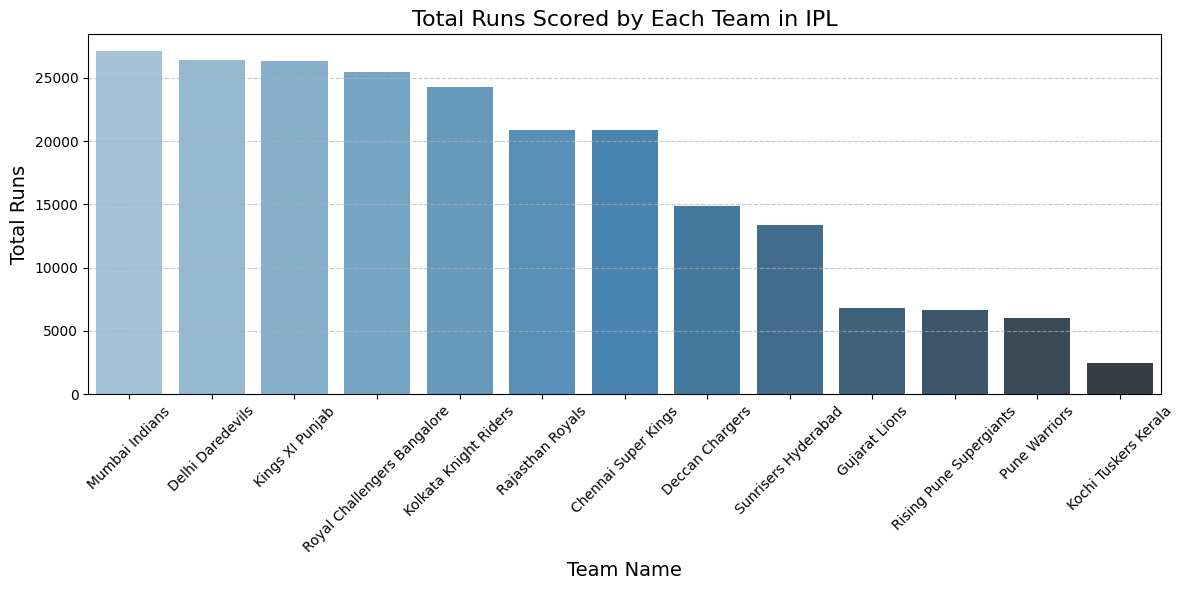

In [277]:
team_runs_df = ball_by_ball_df.groupBy('battingteam_sk').agg(
    F.sum('runs_scored').alias('total_runs')
)

team_runs_with_names = team_runs_df.join(
    team_df,
    team_runs_df.battingteam_sk == team_df.team_sk,'inner').select(team_df.team_name,team_runs_df.total_runs).orderBy(F.desc('total_runs'))

team_runs_pd = team_runs_with_names.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='team_name', y='total_runs', data=team_runs_pd, palette='Blues_d')

plt.title('Total Runs Scored by Each Team in IPL', fontsize=16)
plt.xlabel('Team Name', fontsize=14)
plt.ylabel('Total Runs', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 1.2. Total Wickets Taken by Each Team Across All Seasons

<ipython-input-278-b4b5315c7f6a>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='team_name', y='total_wickets', data=team_wickets_pd, palette='muted')


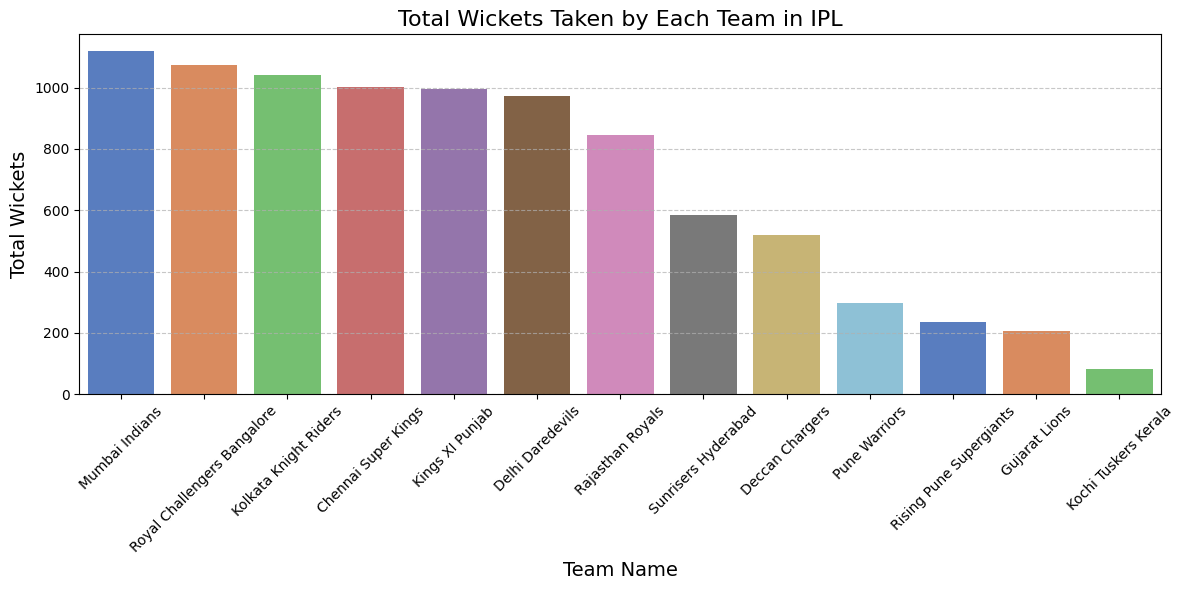

In [278]:
team_wickets_df = ball_by_ball_df.filter(ball_by_ball_df['bowler_wicket'] == 1) \
    .groupBy('bowlingteam_sk').agg(
        F.count('bowler_wicket').alias('total_wickets')
    )

team_wickets_with_names = team_wickets_df.join(
    team_df,
    team_wickets_df.bowlingteam_sk == team_df.team_sk,
    'inner'
).select(
    team_df.team_name,
    team_wickets_df.total_wickets
).orderBy(F.desc('total_wickets'))

team_wickets_pd = team_wickets_with_names.toPandas()

plt.figure(figsize=(12, 6))

sns.barplot(x='team_name', y='total_wickets', data=team_wickets_pd, palette='muted')

plt.title('Total Wickets Taken by Each Team in IPL', fontsize=16)
plt.xlabel('Team Name', fontsize=14)
plt.ylabel('Total Wickets', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 1.3. Most Successful Teams per Season

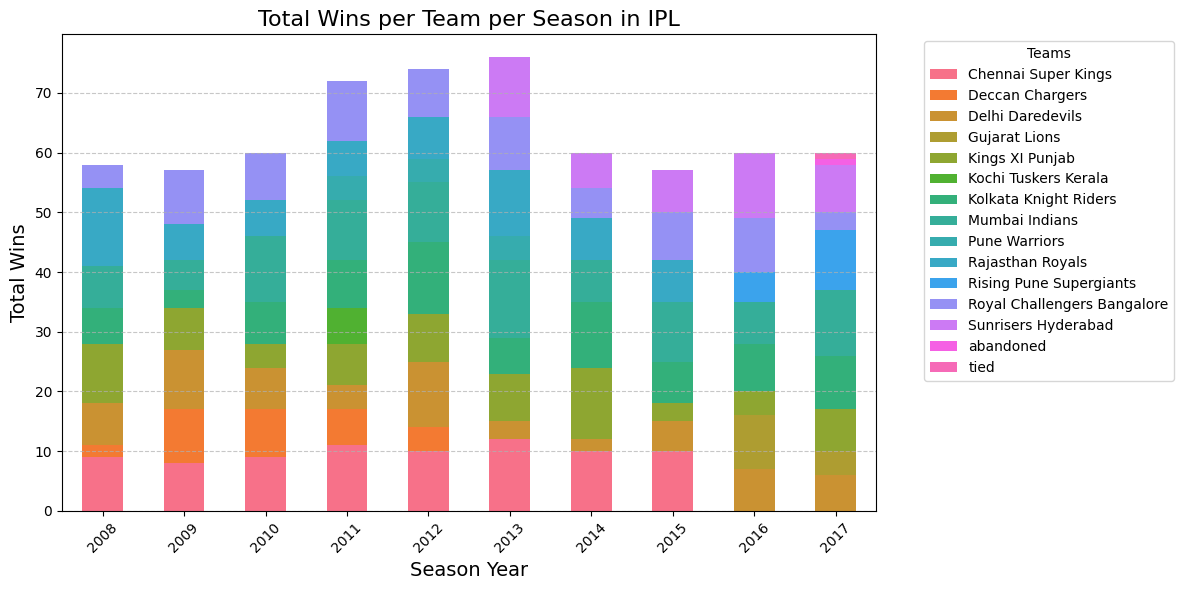

In [279]:
team_wins_per_season = match_df.groupBy('match_winner', 'season_year').agg(F.count('match_id').alias('total_wins')).orderBy(F.desc('total_wins'))

team_wins_per_season_pd = team_wins_per_season.toPandas()

team_wins_per_season_pd.replace('NULL', None, inplace=True)
team_wins_per_season_pd = team_wins_per_season_pd.dropna()

pivot_df = team_wins_per_season_pd.pivot(index='season_year', columns='match_winner', values='total_wins').fillna(0)

num_teams = len(pivot_df.columns)

colors = sns.color_palette("husl", num_teams)
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Total Wins per Team per Season in IPL', fontsize=16)
plt.xlabel('Season Year', fontsize=14)
plt.ylabel('Total Wins', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Teams', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# 2. Player Performance Insights

## 2.1. Top Run Scorers

<ipython-input-280-90784bb3d650>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player_name', y='total_runs', data=top_batsmen_pd, palette='viridis')


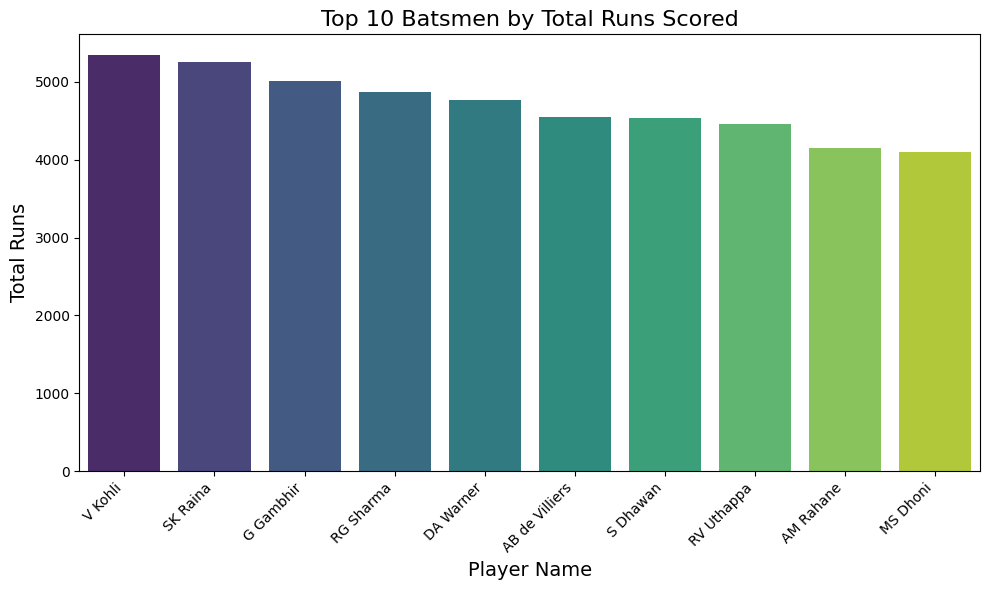

In [280]:
top_batsmen = ball_by_ball_df.join(player_df, ball_by_ball_df["Striker"] == player_df["player_id"]) \
    .groupBy("player_name") \
    .agg(sum("Runs_Scored").alias("total_runs")) \
    .orderBy(desc("total_runs"))

top_batsmen_pd = top_batsmen.limit(10).toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.barplot(x='player_name', y='total_runs', data=top_batsmen_pd, palette='viridis')

plt.xticks(rotation=45, ha='right')

plt.title('Top 10 Batsmen by Total Runs Scored', fontsize=16)
plt.xlabel('Player Name', fontsize=14)
plt.ylabel('Total Runs', fontsize=14)

plt.tight_layout()
plt.show()

## 2.2. Top Wicket-Takers

<ipython-input-281-7d2653e730fa>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player_name', y='total_wickets', data=top_bowlers_df, palette='viridis')


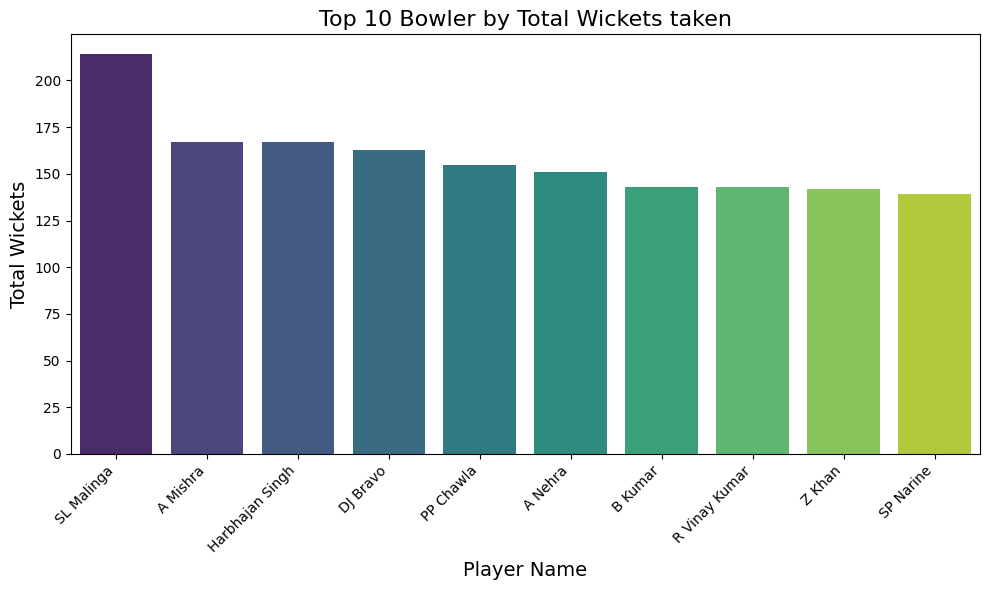

In [281]:
player_wickets = ball_by_ball_df.filter(
    ball_by_ball_df['out_type'] != 'Not Applicable'
).groupBy('bowler').agg(
    F.count('out_type').alias('total_wickets')
)

joined_df = player_wickets.join(player_df, player_wickets.bowler == player_df.player_id, how="inner")

top_bowlers_df = joined_df.select(player_df["player_name"], player_wickets["total_wickets"]) \
                           .orderBy(player_wickets["total_wickets"].desc()) \
                           .limit(10) \
                           .toPandas()

plt.figure(figsize=(10, 6))

sns.barplot(x='player_name', y='total_wickets', data=top_bowlers_df, palette='viridis')

plt.xticks(rotation=45, ha='right')

plt.title('Top 10 Bowler by Total Wickets taken', fontsize=16)
plt.xlabel('Player Name', fontsize=14)
plt.ylabel('Total Wickets', fontsize=14)

plt.tight_layout()
plt.show()


## 2.3.  Consistency in Performance (Matches Played vs Runs/Wickets)

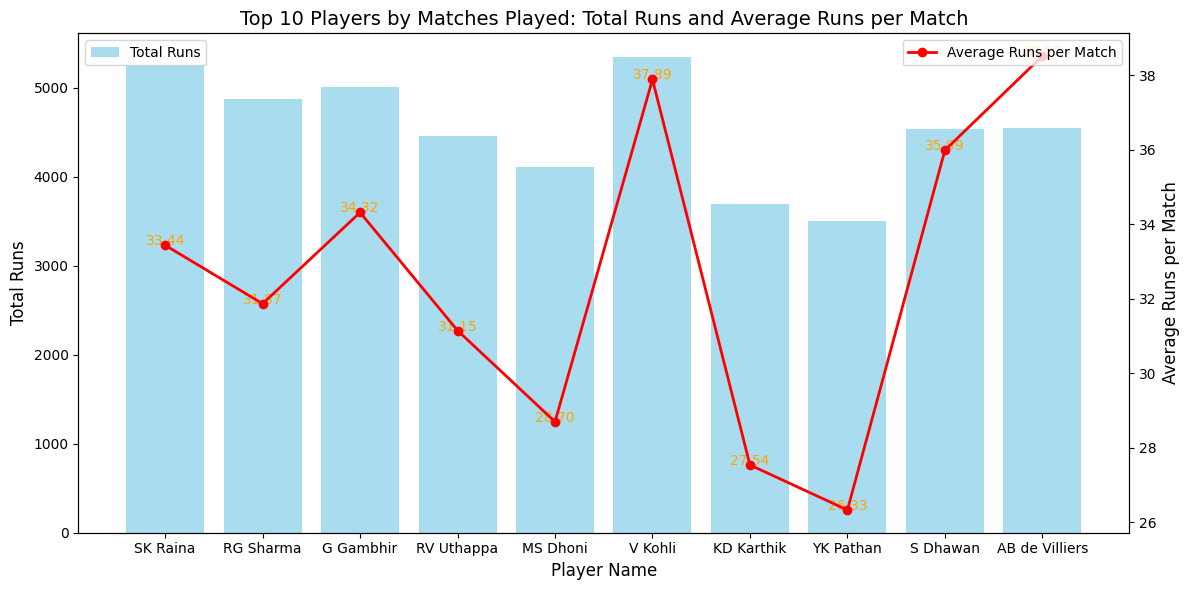

In [282]:
player_match_count = ball_by_ball_df.groupBy('striker').agg(
    F.countDistinct('match_id').alias('matches_played'),
    F.sum('runs_scored').alias('total_runs')
)

joined_df = player_match_count.join(player_df, player_match_count.striker == player_df.player_id, how='inner')

result_df = joined_df.select(player_df["player_name"], player_match_count["matches_played"], player_match_count["total_runs"]) \
                      .withColumn('average_runs_per_match',
                                  F.format_number(
                                      F.when(player_match_count["matches_played"] > 0,
                                              player_match_count["total_runs"] / player_match_count["matches_played"])
                                      .otherwise(0), 2)) \
                      .orderBy(player_match_count["total_runs"].desc())

pandas_df = result_df.toPandas()

top_10_players = pandas_df.nlargest(10, 'matches_played')

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(top_10_players['player_name'], top_10_players['total_runs'],
        color='skyblue', label='Total Runs', alpha=0.7)
ax1.set_xlabel('Player Name', fontsize=12)
ax1.set_ylabel('Total Runs', fontsize=12)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(top_10_players['player_name'], top_10_players['average_runs_per_match'].astype(float),
         color='red', marker='o', label='Average Runs per Match', linewidth=2, zorder=5)
ax2.set_ylabel('Average Runs per Match', fontsize=12)
ax2.tick_params(axis='y')

for index, row in top_10_players.iterrows():
    ax2.text(row['player_name'], float(row['average_runs_per_match']),
             f"{float(row['average_runs_per_match']):.2f}", horizontalalignment='center', color='orange')

plt.title('Top 10 Players by Matches Played: Total Runs and Average Runs per Match', fontsize=14)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

<Figure size 1600x600 with 0 Axes>

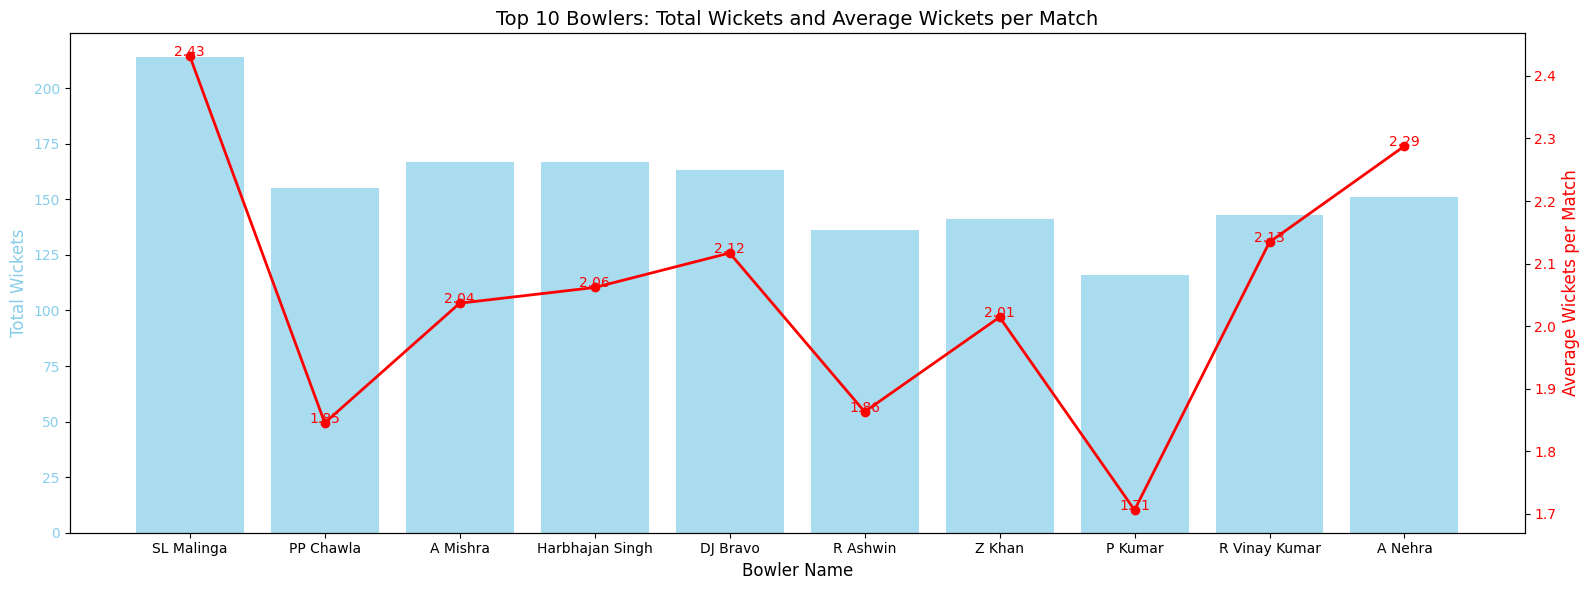

In [283]:
bowler_match_count = ball_by_ball_df.filter(ball_by_ball_df['bowler_wicket'] == True).groupBy('bowler').agg(
    F.countDistinct('match_id').alias('matches_played'),
    F.count('bowler_wicket').alias('total_wickets')
)

joined_bowler_df = bowler_match_count.join(player_df, bowler_match_count.bowler == player_df.player_id, how='inner')


result_bowler_df = joined_bowler_df.select(
    player_df["player_name"],
    bowler_match_count["matches_played"],
    bowler_match_count["total_wickets"]
).withColumn(
    'average_wickets_per_match',
    F.when(bowler_match_count["matches_played"] > 0,
           bowler_match_count["total_wickets"] / bowler_match_count["matches_played"])
    .otherwise(0)
).orderBy(bowler_match_count["total_wickets"].desc())

# Show the results
# result_bowler_df.show()

pandas_bowler_df = result_bowler_df.toPandas()

# Filter for top 10 bowlers by matches played
top_10_bowlers = pandas_bowler_df.nlargest(10, 'matches_played')

# Set the figure size (increase the width)
plt.figure(figsize=(16, 6))  # Increase the width to 16
fig, ax1 = plt.subplots(figsize=(16, 6))  # Increase the width to 16

# Bar chart for total wickets
color = 'skyblue'
ax1.set_xlabel('Bowler Name', fontsize=12)
ax1.set_ylabel('Total Wickets', fontsize=12, color=color)
ax1.bar(top_10_bowlers['player_name'], top_10_bowlers['total_wickets'], color=color, alpha=0.7, label='Total Wickets')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for average wickets per match
ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('Average Wickets per Match', fontsize=12, color=color)
ax2.plot(top_10_bowlers['player_name'], top_10_bowlers['average_wickets_per_match'], color=color, marker='o', linewidth=2, label='Average Wickets per Match')
ax2.tick_params(axis='y', labelcolor=color)

# Add data labels for average wickets per match
for index, row in top_10_bowlers.iterrows():
    ax2.text(row['player_name'], row['average_wickets_per_match'],
             f"{row['average_wickets_per_match']:.2f}", horizontalalignment='center', color=color)

# Set the title
plt.title('Top 10 Bowlers: Total Wickets and Average Wickets per Match', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

# 3. Match and Toss Insights

## 3.1. Toss Decision Impact on Match Outcome

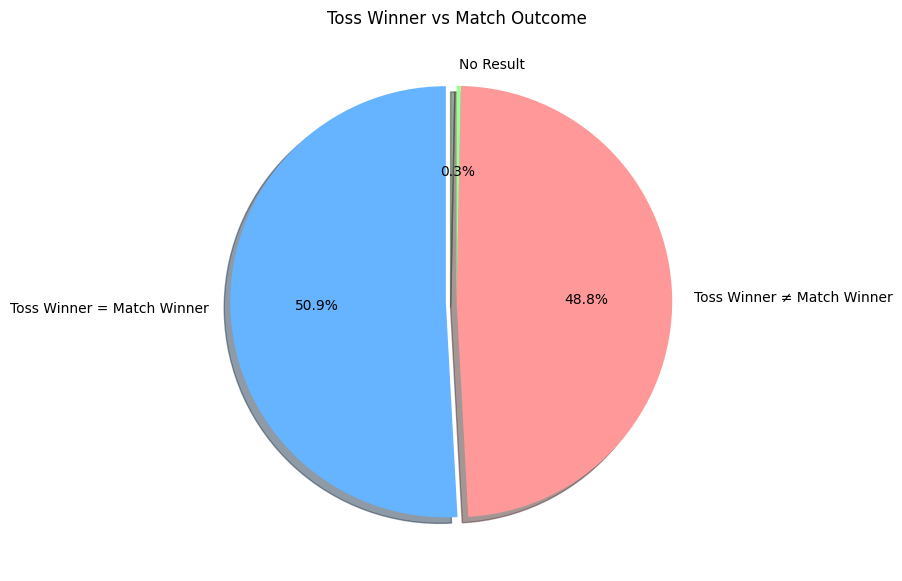

In [284]:
toss_match_wins = match_df.filter(match_df['toss_winner'] == match_df['match_winner']).count() / match_df.count() * 100

toss_match_loss = match_df.filter((match_df['toss_winner'] != match_df['match_winner']) &
                                  (match_df['match_winner'] != 'tied') &
                                  (match_df['match_winner'] != 'abandoned')).count() / match_df.count() * 100

toss_match_noresult = match_df.filter((match_df['match_winner'] == 'tied') |
                                      (match_df['match_winner'] == 'abandoned')).count() / match_df.count() * 100

labels = ['Toss Winner = Match Winner', 'Toss Winner ≠ Match Winner', 'No Result']
sizes = [toss_match_wins, toss_match_loss, toss_match_noresult]
colors = ['#66b3ff', '#ff9999', '#99ff99']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.05, 0, 0), shadow=True)
plt.title('Toss Winner vs Match Outcome')
plt.show()

## 3.2. Match Outcomes (Win by Runs or Wickets)

<ipython-input-285-47396077cac3>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_types, y=win_counts, palette='viridis')


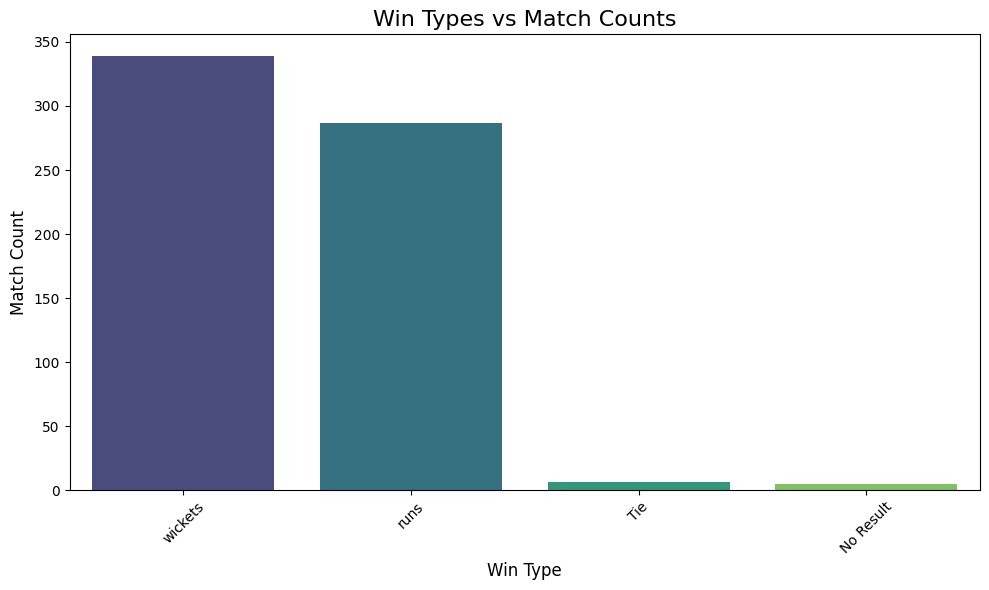

In [285]:
win_type_count = match_df.groupBy('win_type').agg(F.count('match_id').alias('win_count')).orderBy(F.desc('win_count'))

win_type_count_pd = win_type_count.toPandas()

win_types = win_type_count_pd['win_type']
win_counts = win_type_count_pd['win_count']

plt.figure(figsize=(10, 6))
sns.barplot(x=win_types, y=win_counts, palette='viridis')

plt.title('Win Types vs Match Counts', fontsize=16)
plt.xlabel('Win Type', fontsize=12)
plt.ylabel('Match Count', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 3.3. Team Performance After Winning Toss

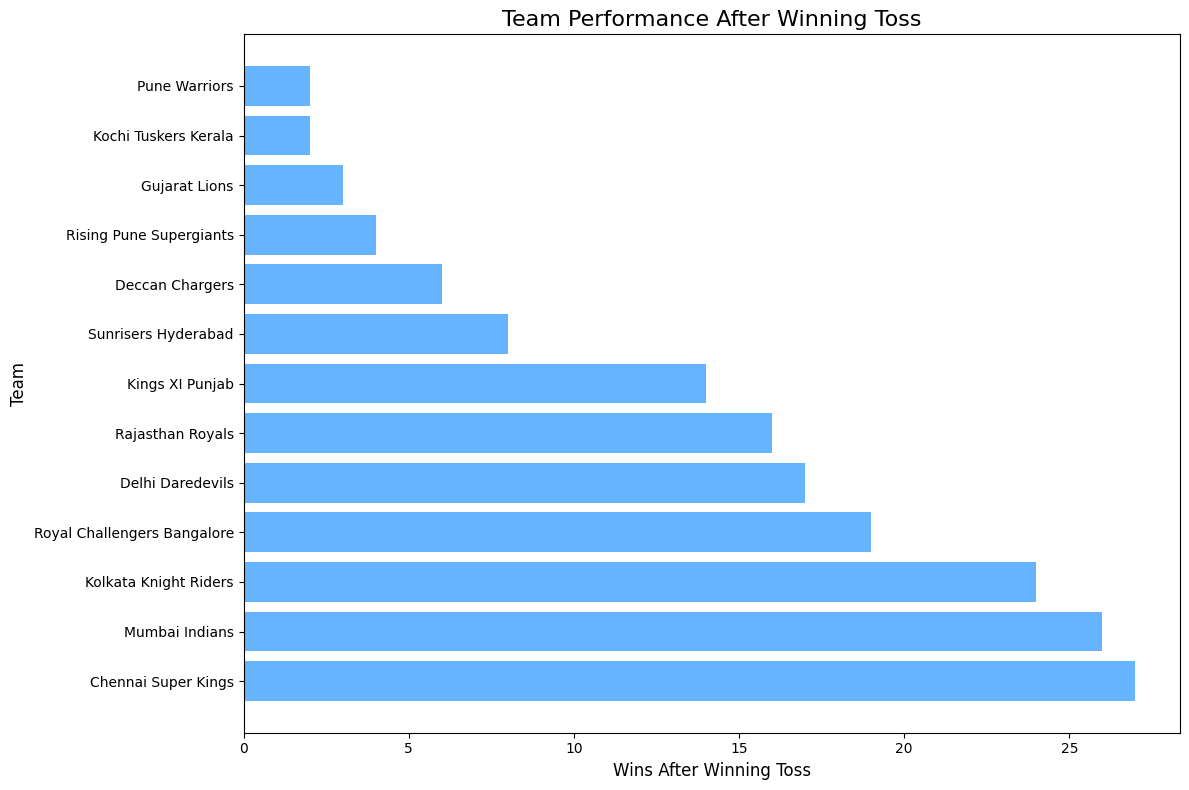

In [286]:
team_toss_win_performance = spark.sql("""
SELECT team1, COUNT(*) AS matches_played, SUM(CASE WHEN toss_winner = match_winner THEN 1 ELSE 0 END) AS wins_after_toss
FROM match
WHERE toss_winner = team1
GROUP BY team1
ORDER BY wins_after_toss DESC
""")
team_toss_win_pd = team_toss_win_performance.toPandas()

plt.figure(figsize=(12, 8))

plt.barh(team_toss_win_pd['team1'], team_toss_win_pd['wins_after_toss'], color='#66b3ff')

plt.title('Team Performance After Winning Toss', fontsize=16)
plt.xlabel('Wins After Winning Toss', fontsize=12)
plt.ylabel('Team', fontsize=12)

plt.tight_layout()

plt.show()

# 4. Season Insights

## 4.1. Season-wise Total Runs   -------------------------remove

In [287]:
# top_scoring_batsmen_per_season = spark.sql("""
# WITH PlayerRunsPerSeason AS (
#     SELECT
#         p.player_name,
#         m.season_year,
#         SUM(b.runs_scored) AS total_runs,
#         ROW_NUMBER() OVER (PARTITION BY m.season_year ORDER BY SUM(b.runs_scored) DESC) AS rank
#     FROM ball_by_ball b
#     JOIN match m ON b.match_id = m.match_id
#     JOIN player_match pm ON m.match_id = pm.match_id AND b.striker = pm.player_id
#     JOIN player p ON p.player_id = pm.player_id
#     GROUP BY p.player_name, m.season_year
# )
# SELECT
#     player_name,
#     season_year,
#     total_runs
# FROM PlayerRunsPerSeason
# WHERE rank = 1
# ORDER BY season_year;
# """)
# top_scoring_batsmen_per_season.show(30)

## 4.2. Season-wise Total Wickets----------------------remove

In [288]:
# top_wicket_bowler_per_season = spark.sql("""
# WITH PlayerWicketsPerSeason AS (
#     SELECT
#         p.player_name,
#         m.season_year,
#         SUM(b.bowler_wicket) AS total_wicket,
#         ROW_NUMBER() OVER (PARTITION BY m.season_year ORDER BY SUM(b.bowler_wicket) DESC) AS rank
#     FROM ball_by_ball b
#     JOIN match m ON b.match_id = m.match_id
#     JOIN player_match pm ON m.match_id = pm.match_id AND b.bowler = pm.player_id
#     JOIN player p ON p.player_id = pm.player_id
#     WHERE b.bowler_wicket = 1 and out_type IN ('Keeper Catch', 'bowled', 'caught', 'stumped', 'lbw', 'caught and bowled', 'hit wicket', 'obstructing the field')
#     GROUP BY p.player_name, m.season_year
# )
# SELECT
#     player_name,
#     season_year,
#     total_wicket
# FROM PlayerWicketsPerSeason
# WHERE rank = 1
# ORDER BY season_year;
# """)

# top_wicket_bowler_per_season.show(30)


In [289]:
# economical_bowlers_powerplay = spark.sql("""
# SELECT
#     p.player_name,
#     ROUND(AVG(b.runs_scored) * 6, 2) AS avg_runs_per_over,
#     sum(bowler_wicket) AS total_wickets
# FROM
#     ball_by_ball b
# JOIN
#     player_match pm ON b.match_id = pm.match_id AND b.bowler = pm.player_id
# JOIN
#     player p ON pm.player_id = p.player_id
# WHERE
#     b.over_id <= 6
# GROUP BY
#     p.player_name
# HAVING
#     COUNT(*) >= 1
# ORDER BY
#     total_wickets DESC,
#     avg_runs_per_over;
# """)
# economical_bowlers_powerplay.show()


In [290]:
# average_runs_in_powerplay = spark.sql('''WITH cte AS (
#     SELECT
#         Team_Batting,
#         SUM(Runs_scored) AS runs,
#         COUNT(DISTINCT match_id) AS match_count
#     FROM
#         ball_by_ball
#     WHERE
#         over_id < 7
#     GROUP BY
#         Team_Batting
# )
# SELECT
#     b.Team_name,
#     ROUND((SUM(runs) / MAX(match_count)), 2) AS average_runs
# FROM
#     cte a
#     INNER JOIN team b
#     ON a.Team_Batting = b.team_sk
# GROUP BY
#     b.Team_name
# ORDER BY
#     average_runs DESC;
# ''')

# average_runs_in_powerplay.show()

# 5. Venue and City Insights

## 5.1. Most Popular Venues for IPL Matches

<ipython-input-291-8d787c095d3f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_matches, y=venues, palette='Blues')


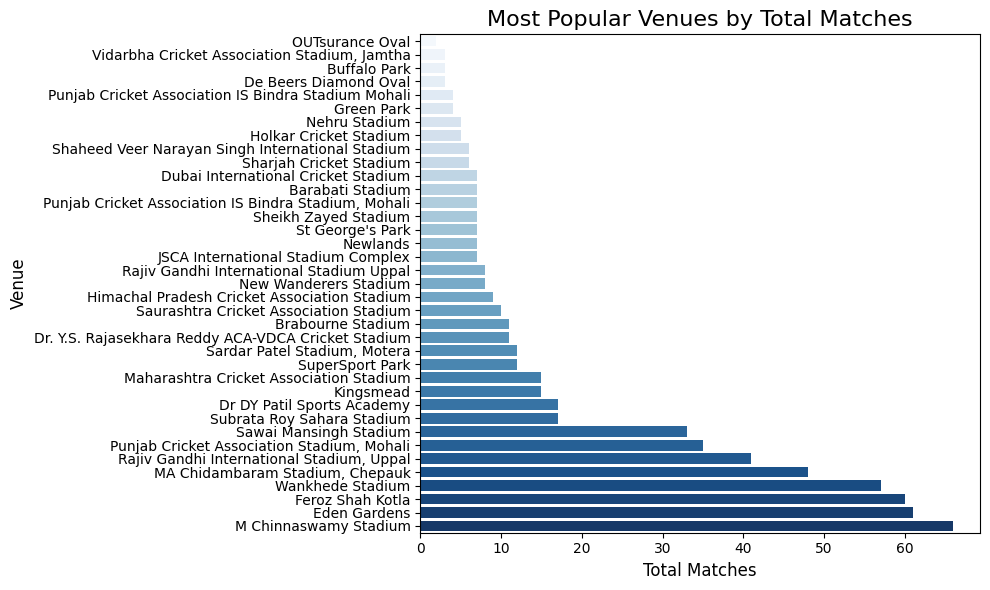

In [291]:
venue_count = match_df.groupBy('venue_name').agg(F.count('match_id').alias('total_matches')).orderBy(F.asc('total_matches'))
venue_count = venue_count.filter(venue_count['venue_name'] != 'NULL')

venue_count_pd = venue_count.toPandas()

venues = venue_count_pd['venue_name']
total_matches = venue_count_pd['total_matches']

plt.figure(figsize=(10, 6))
sns.barplot(x=total_matches, y=venues, palette='Blues')

plt.title('Most Popular Venues by Total Matches', fontsize=16)
plt.xlabel('Total Matches', fontsize=12)
plt.ylabel('Venue', fontsize=12)

plt.tight_layout()
plt.show()

## 5.2. Most Popular Cities for IPL Matches

<ipython-input-292-4f3eeccc45ca>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='city_name', y='total_matches', data=city_count_pd, palette='Blues_d')


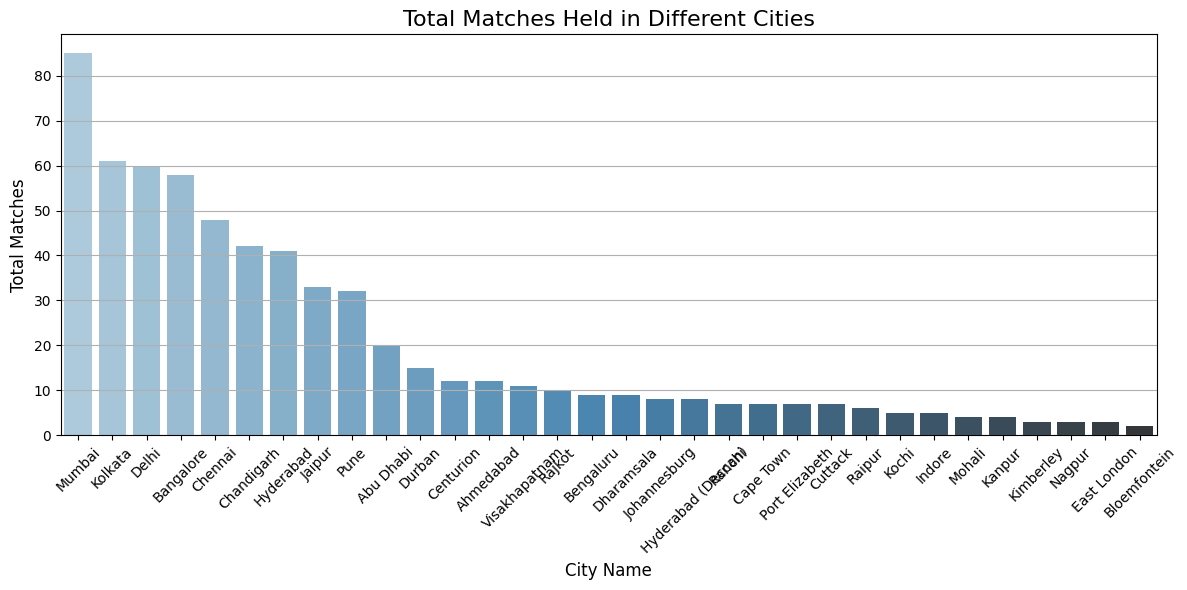

In [292]:
city_count = match_df.groupBy('city_name').agg(F.count('match_id').alias('total_matches')).orderBy(F.desc('total_matches'))

city_count_pd = city_count.toPandas()

city_count_pd = city_count_pd.sort_values(by='total_matches', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='city_name', y='total_matches', data=city_count_pd, palette='Blues_d')

plt.xticks(rotation=45)
plt.title('Total Matches Held in Different Cities', fontsize=16)
plt.xlabel('City Name', fontsize=12)
plt.ylabel('Total Matches', fontsize=12)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## 5.3. Home Ground Advantage in Match

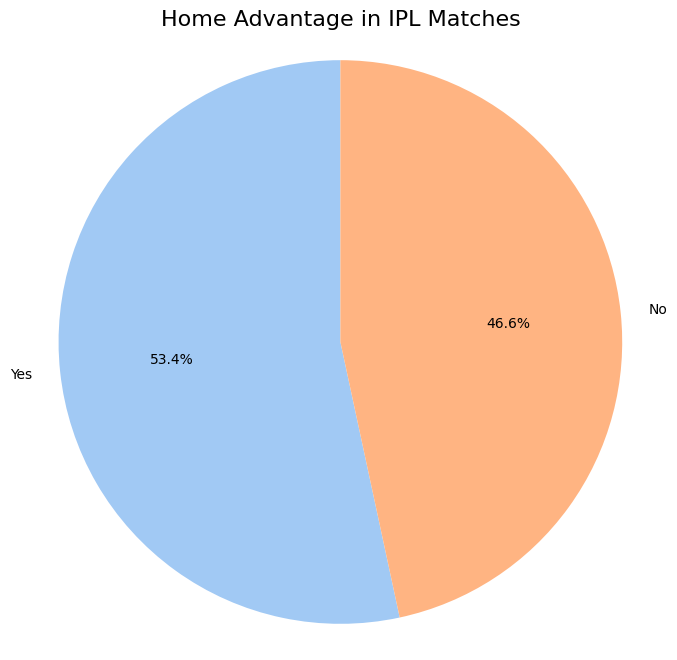

In [293]:
home_advantage = match_df.withColumn("is_home_win", match_df["match_winner"] == match_df["team1"]).groupBy("is_home_win").count()

home_advantage_pd = home_advantage.toPandas()

home_advantage_pd['is_home_win'] = home_advantage_pd['is_home_win'].map({True: 'Yes', False: 'No'})

plt.figure(figsize=(8, 8))
plt.pie(home_advantage_pd['count'], labels=home_advantage_pd['is_home_win'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))

plt.title('Home Advantage in IPL Matches', fontsize=16)
plt.axis('equal')

plt.show()


## 5.4. Average Runs Scored in Each Venue

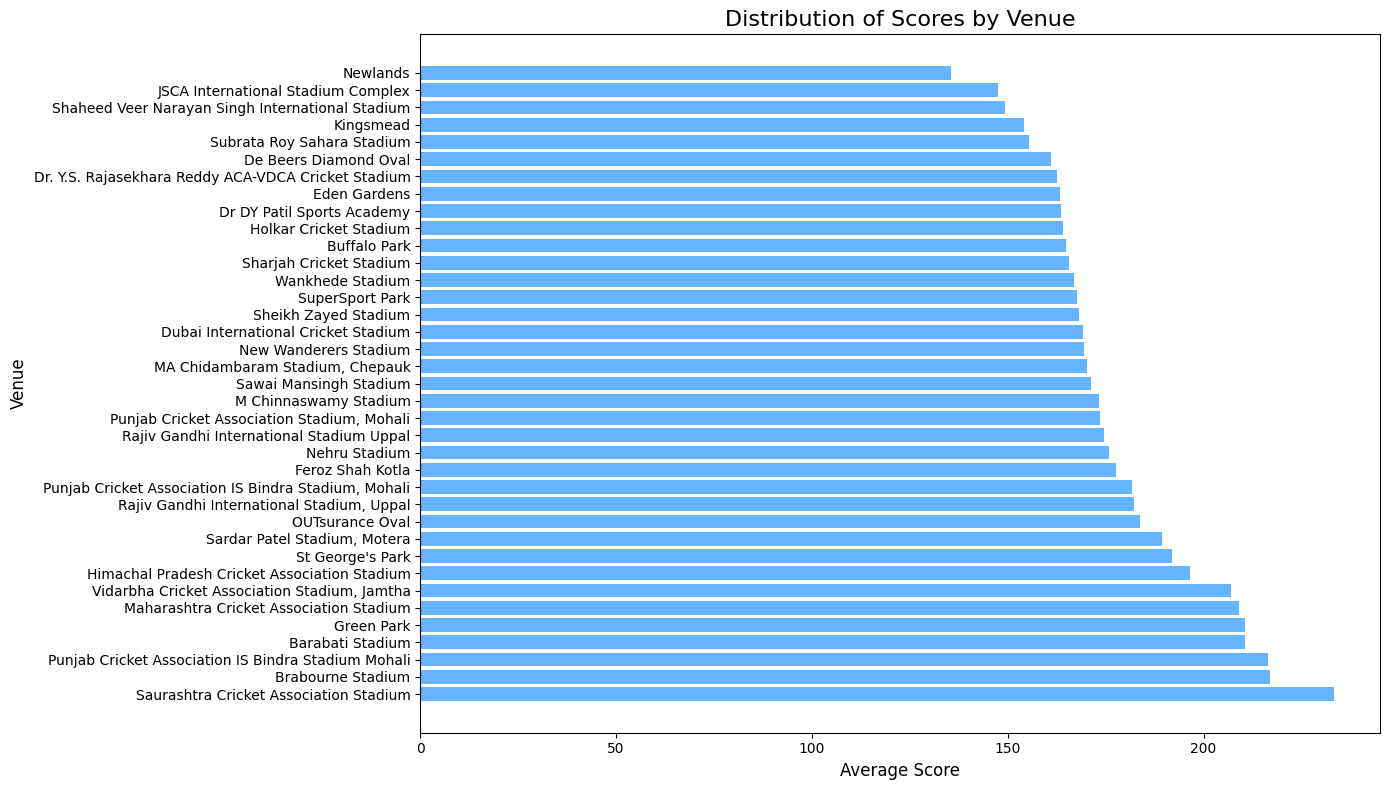

In [294]:
scores_by_venue = spark.sql("""
SELECT venue_name, AVG(total_runs)/2 AS average_score, MAX(total_runs) AS highest_score
FROM (
    SELECT ball_by_ball.match_id, match.venue_name, SUM(runs_scored) AS total_runs
    FROM ball_by_ball
    JOIN match ON ball_by_ball.match_id = match.match_id
    GROUP BY ball_by_ball.match_id, match.venue_name
)
GROUP BY venue_name
ORDER BY average_score DESC
""")

scores_by_venue_pd = scores_by_venue.toPandas()

plt.figure(figsize=(14, 8))

plt.barh(scores_by_venue_pd['venue_name'], scores_by_venue_pd['average_score'], color='#66b3ff')

plt.title('Distribution of Scores by Venue', fontsize=16)
plt.xlabel('Average Score', fontsize=12)
plt.ylabel('Venue', fontsize=12)

plt.tight_layout()
plt.show()


# 6. Fielding and Extras Insights

## 6.1. Top Players Involved in Run Outs

<ipython-input-295-10fb593b367d>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=run_out_counts, y=player_names, palette='coolwarm')


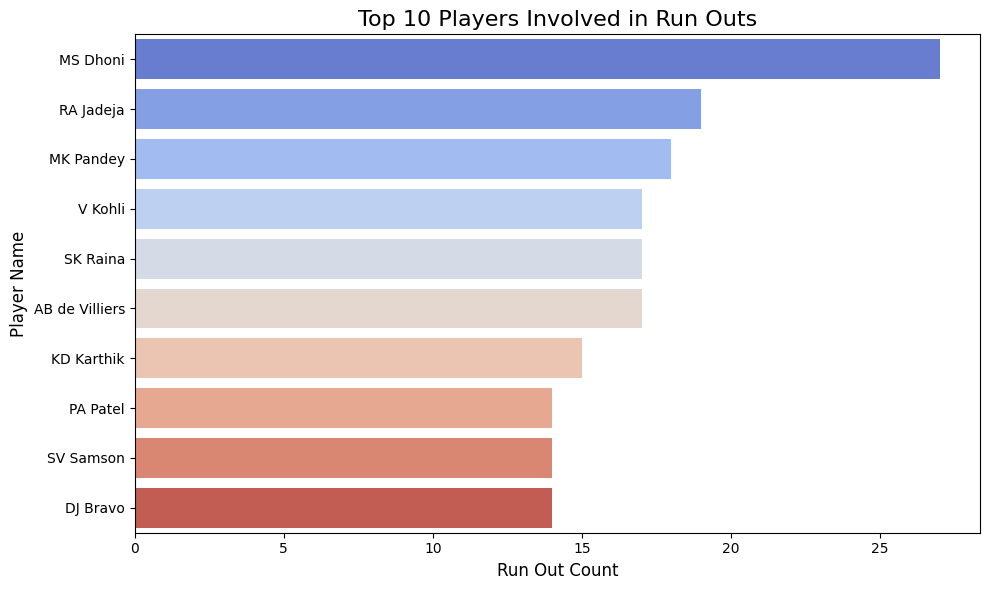

In [295]:
run_outs = ball_by_ball_df.filter(ball_by_ball_df['out_type'] == 'run out') \
                          .groupBy('fielder_sk') \
                          .agg(F.count('out_type').alias('run_out_count')) \
                          .orderBy(F.desc('run_out_count'))

run_outs_with_names = run_outs.join(player_df, run_outs['fielder_sk'] == player_df['player_sk'], 'inner') \
                                .select(player_df['player_name'], run_outs['run_out_count'])

top_run_outs_with_names = run_outs_with_names.orderBy(F.desc('run_out_count')).limit(10)

top_run_outs_pd = top_run_outs_with_names.toPandas()

player_names = top_run_outs_pd['player_name']
run_out_counts = top_run_outs_pd['run_out_count']

plt.figure(figsize=(10, 6))
sns.barplot(x=run_out_counts, y=player_names, palette='coolwarm')

plt.title('Top 10 Players Involved in Run Outs', fontsize=16)
plt.xlabel('Run Out Count', fontsize=12)
plt.ylabel('Player Name', fontsize=12)

plt.tight_layout()
plt.show()

## 6.2. Total Extras per Match and Season------------------review


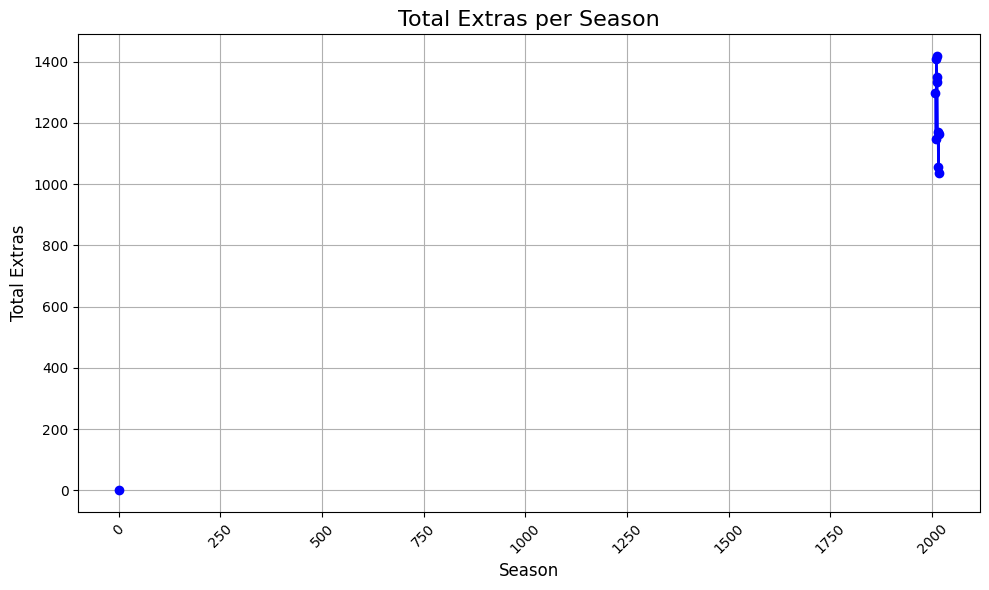

In [296]:
# Total extras per match and season
extras = ball_by_ball_df.withColumn('total_extras', F.col('wides') + F.col('noballs') + F.col('byes') + F.col('legbyes') + F.col('penalty'))
season_extras = extras.groupBy('season').agg(F.sum('total_extras').alias('total_extras')).orderBy(F.asc('season'))
# season_extras.show()

season_extras_pd = season_extras.toPandas()

# Extract seasons and total extras
seasons = season_extras_pd['season']
total_extras = season_extras_pd['total_extras']

# Create a line plot
plt.figure(figsize=(10, 6))  # Set figure size for better readability
plt.plot(seasons, total_extras, marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title('Total Extras per Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Extras', fontsize=12)

# Add grid and improve layout
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()


# 7. Key Factors for Player Selection

## 7.1. Player Batting Performance
### Factor: Runs scored, Strike Rate, and Consistency
  ***Rating=0.5×avg_runs_per_match+0.3×strike_rate+0.2×total_runs***
### Key Metric: Total runs scored, average runs per match, and strike rate.
### Insight: Top-performing batsmen with consistent runs across matches and seasons should be prioritized. Players who have a high strike rate, especially in key overs (powerplay and death overs), will be more valuable in aggressive game situations.


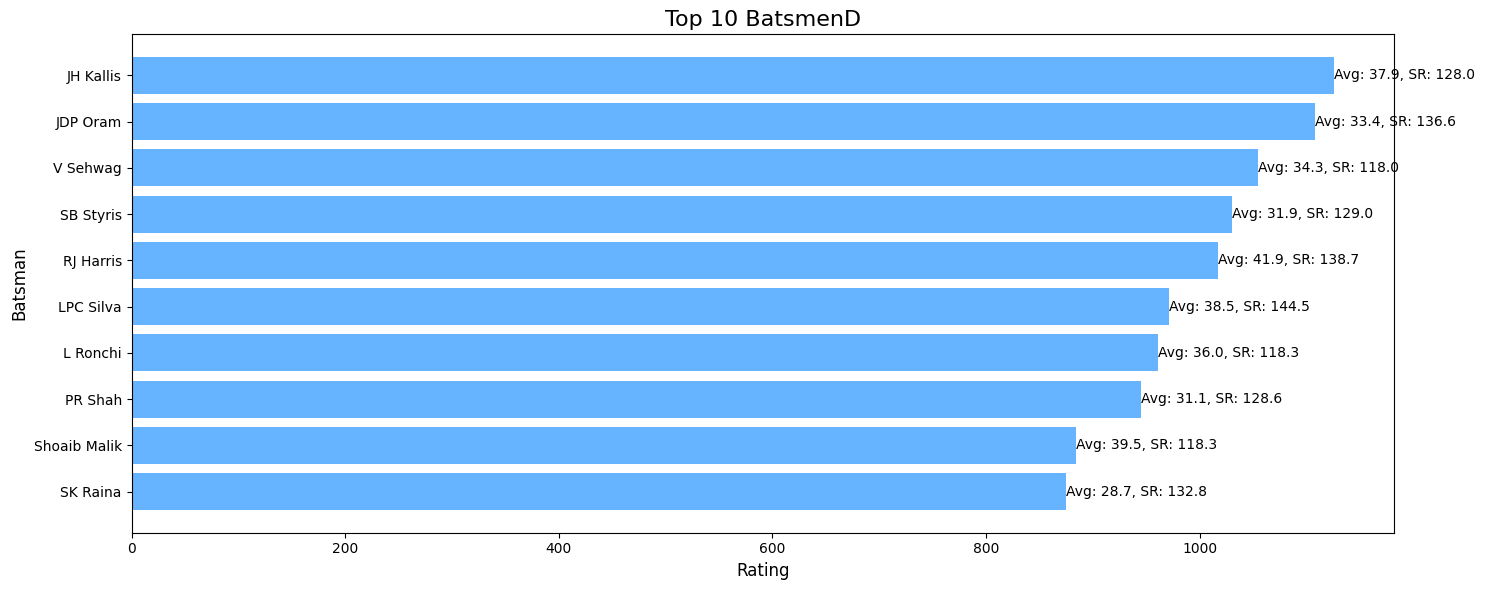

In [297]:
batsman_performance = ball_by_ball_df.groupBy('striker').agg(
    F.sum('runs_scored').alias('total_runs'),
    F.countDistinct('match_id').alias('matches_played'),
    (F.sum('runs_scored') / F.countDistinct('match_id')).alias('avg_runs_per_match'),
    ((F.sum('runs_scored') / F.count('ball_id'))*100).alias('strike_rate')
).orderBy(F.desc('total_runs'))

batsman_performance_with_rating = batsman_performance.withColumn(
    'rating',
    0.5 * F.col('avg_runs_per_match') +
    0.3 * F.col('strike_rate') +
    0.2 * F.col('total_runs')
)

top_batsmen = batsman_performance_with_rating.orderBy(F.desc('rating')).limit(10)

top_batsmen_with_names = top_batsmen.join(player_df, top_batsmen['striker'] == player_df['player_sk'], 'inner') \
                                     .select(player_df['player_name'], top_batsmen['avg_runs_per_match'], top_batsmen['strike_rate'], top_batsmen['rating'])

top_batsmen_pd = top_batsmen_with_names.toPandas()
top_batsmen_pd = top_batsmen_pd.sort_values(by='rating', ascending=True)

player_names = top_batsmen_pd['player_name']
ratings = top_batsmen_pd['rating']
avg_runs = top_batsmen_pd['avg_runs_per_match']
strike_rates = top_batsmen_pd['strike_rate']

plt.figure(figsize=(15, 6))
bars = plt.barh(player_names, ratings, color='#66b3ff')

for bar, avg, sr in zip(bars, avg_runs, strike_rates):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'Avg: {avg:.1f}, SR: {sr:.1f}',
             va='center', ha='left', fontsize=10)

plt.title('Top 10 BatsmenD', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Batsman', fontsize=12)

plt.tight_layout()

plt.show()

### Strategy:
Select batsmen with high average runs and strike rate, especially when facing strong bowling line-ups.
Consider left-hand and right-hand combinations based on bowler type (e.g., right-arm off-spinners vs. left-hand batsmen)


## 7.2. Player Bowling Performance
### Factor: Wickets taken, Economy Rate, and Wicket-Taking Ability in Crucial Overs
### Key Metric: Total wickets, average wickets per match, and economy rate.
### Insight: Bowlers with the ability to take wickets in key overs (powerplay and death overs) are critical for success. A low economy rate, especially in death overs, can prevent opponents from accelerating their run rate.

In [298]:
# Calculate total wickets, average wickets per match, and economy rate for each bowler
bowler_performance = ball_by_ball_df.filter(ball_by_ball_df['bowler_wicket'] == True).groupBy('bowler').agg(
    F.count('bowler_wicket').alias('total_wickets'),
    (F.count('bowler_wicket') / F.countDistinct('match_id')).alias('avg_wickets_per_match'),
    (F.sum('runs_scored') / F.count('ball_id')).alias('economy_rate')
).orderBy(F.desc('total_wickets'))
bowler_performance.show()


+------+-------------+---------------------+--------------------+
|bowler|total_wickets|avg_wickets_per_match|        economy_rate|
+------+-------------+---------------------+--------------------+
|   194|          214|   2.4318181818181817|0.028037383177570093|
|   136|          167|   2.0365853658536586|0.017964071856287425|
|    50|          167|   2.0617283950617282|0.017964071856287425|
|    71|          163|    2.116883116883117| 0.03067484662576687|
|    67|          155|   1.8452380952380953| 0.01935483870967742|
|    73|          151|    2.287878787878788|0.039735099337748346|
|   299|          143|             2.234375|0.013986013986013986|
|    81|          143|   2.1343283582089554|  0.0979020979020979|
|    15|          141|   2.0142857142857142| 0.04964539007092199|
|   315|          139|    2.396551724137931| 0.04316546762589928|
|   201|          136|   1.8630136986301369| 0.04411764705882353|
|    61|          123|   2.1578947368421053|0.032520325203252036|
|   109|  

In [299]:
# Step 1: Calculate total runs given and overs bowled by each bowler
bowler_performance = ball_by_ball_df.groupBy('bowler').agg(
    F.count('bowler_wicket').alias('total_wickets'),
    (F.count('bowler_wicket') / F.countDistinct('match_id')).alias('avg_wickets_per_match'),
    F.sum('runs_scored').alias('total_runs'),  # Total runs given by the bowler
    F.countDistinct('over_id').alias('total_overs')  # Total overs bowled
)

# Step 2: Calculate the economy rate
bowler_performance = bowler_performance.withColumn('economy_rate',
    F.when(F.col('total_overs') > 0, F.col('total_runs') / F.col('total_overs')).otherwise(0)
)

# Step 3: Round the economy rate to 2 decimal places
bowler_performance = bowler_performance.withColumn('economy_rate', F.round('economy_rate', 2))

# Step 4: Order by total wickets
bowler_performance = bowler_performance.orderBy(F.desc('total_wickets'))

# Show the result
bowler_performance.show()

+------+-------------+---------------------+----------+-----------+------------+
|bowler|total_wickets|avg_wickets_per_match|total_runs|total_overs|economy_rate|
+------+-------------+---------------------+----------+-----------+------------+
|    50|         3664|    27.34328358208955|      4049|         20|      202.45|
|   194|         3266|    29.69090909090909|      3361|         20|      168.05|
|   136|         3217|    25.53174603174603|      3877|         20|      193.85|
|    14|         3095|   26.008403361344538|      3648|         20|       182.4|
|    67|         3081|           24.0703125|      3797|         19|      199.84|
|   201|         2868|   26.555555555555557|      2831|         20|      141.55|
|    15|         2716|   27.434343434343436|      3194|         20|       159.7|
|   299|         2634|   29.266666666666666|      2898|         20|       144.9|
|    81|         2558|    25.07843137254902|      3376|         20|       168.8|
|    71|         2555|   24.

In [300]:
# Calculate total wickets, average wickets per match, and economy rate for each bowler
bowler_performance = ball_by_ball_df.filter(ball_by_ball_df['bowler_wicket'] == True).groupBy('bowler').agg(
    F.count('bowler_wicket').alias('total_wickets'),
    (F.count('bowler_wicket') / F.countDistinct('match_id')).alias('avg_wickets_per_match'),
    (F.sum('runs_scored') / (F.countDistinct('over_id') / 6)).alias('economy_rate')  # Calculate economy rate
).orderBy(F.desc('total_wickets'))

# Round average wickets and economy rate to 2 decimal places
bowler_performance = bowler_performance.withColumn('avg_wickets_per_match', F.round('avg_wickets_per_match', 2)) \
                                         .withColumn('economy_rate', F.round('economy_rate', 2))

# Show the results
bowler_performance.show()


+------+-------------+---------------------+------------+
|bowler|total_wickets|avg_wickets_per_match|economy_rate|
+------+-------------+---------------------+------------+
|   194|          214|                 2.43|        1.89|
|   136|          167|                 2.04|        1.06|
|    50|          167|                 2.06|         0.9|
|    71|          163|                 2.12|        1.58|
|    67|          155|                 1.85|         1.0|
|    73|          151|                 2.29|        2.12|
|   299|          143|                 2.23|        0.67|
|    81|          143|                 2.13|         4.2|
|    15|          141|                 2.01|        2.63|
|   315|          139|                  2.4|         2.0|
|   201|          136|                 1.86|         1.8|
|    61|          123|                 2.16|         1.6|
|   109|          121|                 2.09|        1.89|
|   232|          120|                 2.03|         3.9|
|    94|      

### Strategy:
Select bowlers with high wicket-taking ability in powerplay and death overs.
Focus on economy rate when selecting bowlers for matches with smaller boundaries or high-scoring venues.


## 7.3. Player Fielding and Catching Ability
### Factor: Impact in Run Outs, Catches, and Fielding Positions
### Key Metric: Number of run-outs, catches, and fielding positions.
### Insight: Strong fielders, particularly those who specialize in difficult positions (e.g., inner circle, boundary), can save critical runs and contribute to breaking partnerships through run-outs and catches.

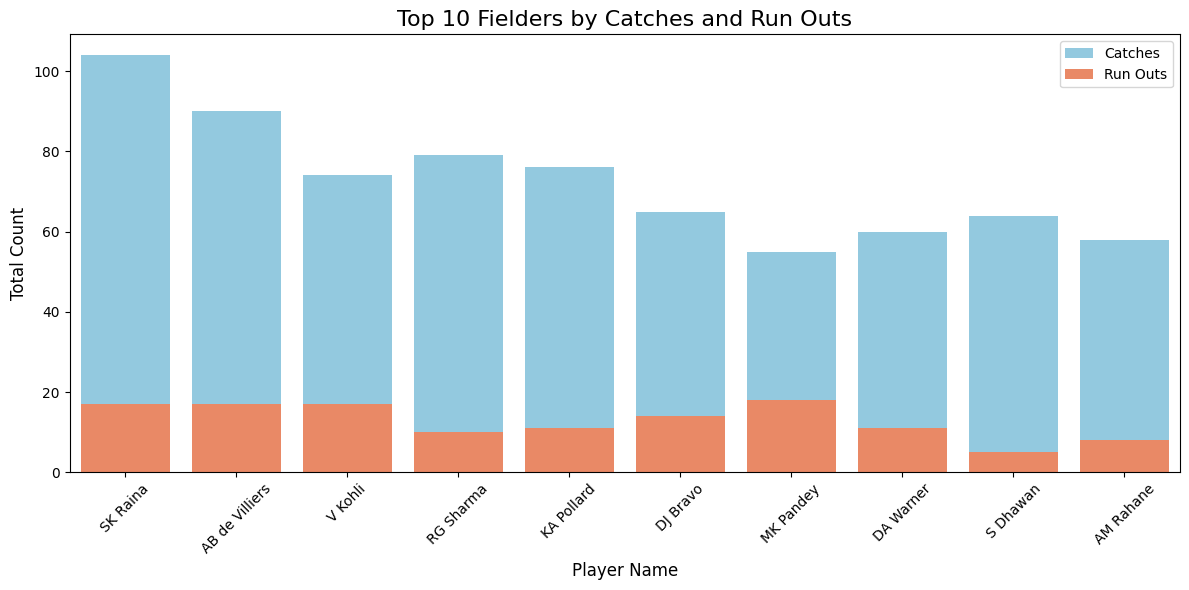

In [301]:
fielder_performance = ball_by_ball_df.filter(
    (ball_by_ball_df['out_type'] == 'caught') | (ball_by_ball_df['out_type'] == 'run out')
).groupBy('fielder_sk').agg(
    F.sum(F.when(ball_by_ball_df['out_type'] == 'caught', 1).otherwise(0)).alias('total_catches'),
    F.sum(F.when(ball_by_ball_df['out_type'] == 'run out', 1).otherwise(0)).alias('total_runouts')
)

fielder_performance_with_names = fielder_performance.join(
    player_df,
    fielder_performance['fielder_sk'] == player_df['player_sk'],
    'inner'
).select(
    player_df['player_name'],
    fielder_performance['total_catches'],
    fielder_performance['total_runouts']
)

top_fielder_performance = fielder_performance_with_names.orderBy(
    (fielder_performance_with_names['total_catches'] + fielder_performance_with_names['total_runouts']).desc()
).limit(10)

top_fielder_performance_pd = top_fielder_performance.toPandas()

plt.figure(figsize=(12, 6))

sns.barplot(data=top_fielder_performance_pd,
            x='player_name',
            y='total_catches',
            color='skyblue',
            label='Catches')

sns.barplot(data=top_fielder_performance_pd,
            x='player_name',
            y='total_runouts',
            color='coral',
            label='Run Outs')

plt.title('Top 10 Fielders by Catches and Run Outs', fontsize=16)
plt.xlabel('Player Name', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()



### Strategy:
Prioritize players with strong fielding skills, particularly in high-pressure matches.
Use players with good fielding abilities in the deep or infield for teams with aggressive batsmen.


## 7.4. Player Fitness and Availability------------age wise peeyush notebook
### Factor: Fitness, Recent Form, and Age
### Key Metric: Player’s recent form, age, and fitness records.
### Insight: While player performance is critical, their fitness and availability can affect long-term performance, especially in high-intensity tournaments. Younger players or those with better fitness might be more reliable over long seasons.


### Strategy:
Rotate players to prevent injuries and fatigue, ensuring a fresh lineup for critical matches.
Consider younger players or recently performing players who are in form, especially if they have had fewer injuries.
